# Imports

In [1]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

2024-03-11 14:51:58.242141: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 14:51:58.247203: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 14:51:58.309932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 14:51:59.786791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Getting Data

## Dataset and Training Parameters

In [2]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCH = 1
GLOBAL_CLIPNORM = 10.0

## Dataset Preparation

In [3]:
class_ids = ["Waldo"]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../raw_data/data/final_waldo/images"
path_annot = "../raw_data/data/final_waldo/Annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

**Next is parsing the XML annotation files to store the labels and bounding box annotations needed for training.**

In [4]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/47 [00:00<?, ?it/s]

**Satisfy very particular input format**

In [5]:
bbox = tf.ragged.constant(bbox, dtype=tf.float32)
classes = tf.ragged.constant(classes, dtype=tf.float32)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

I0000 00:00:1710165122.750452   38562 cuda_executor.cc:1021] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 14:52:02.751005: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2257] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**train/val split**

In [6]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

**Load images, create dataset**

In [7]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

**Create augmentation layers for train set**

In [8]:
augmenter = keras.Sequential(
    layers=[
    keras_cv.layers.RandomFlip(mode="horizontal_and_vertical", bounding_box_format="xyxy"),
        keras_cv.layers.Resizing(
            1024,
            1024,
            pad_to_aspect_ratio=True,
            bounding_box_format="xyxy",
            ),
        keras_cv.layers.RandomRotation(factor=0.15, bounding_box_format="xyxy"),
        keras_cv.layers.Resizing(
            1024,
            1024,
            pad_to_aspect_ratio=True,
            bounding_box_format="xyxy",
            ),
        keras_cv.layers.RandomHue((0.5, 0.5), [0, 255]),
        keras_cv.layers.RandomContrast([0, 255], (0.5, 0.5)),
        keras_cv.layers.RandomSaturation((0.5, 0.5)),
    ]
)

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=False)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
resizing = keras_cv.layers.Resizing(
    1024,
    1024,
    pad_to_aspect_ratio=True,
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualisation

In [10]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

**Visualize train set**

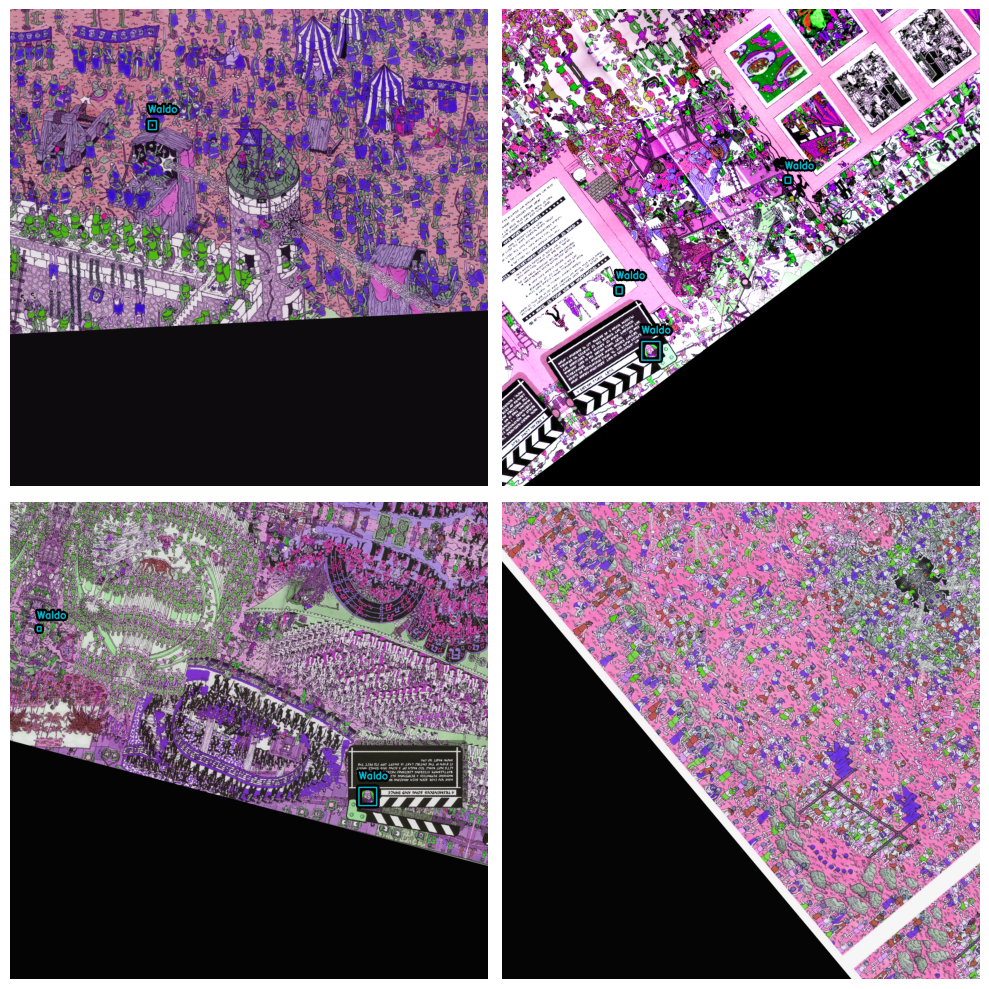

In [11]:
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

**Visualize validation set**

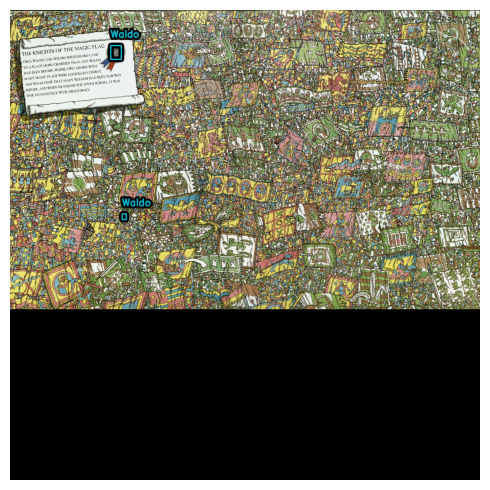

In [12]:
### Doesn't seem to work with val split of 0.1, does work with 0.2
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

**Input handling**

In [13]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Initialize YOLOV8 Model

In [14]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

**Display model architecture**

In [15]:
### uncomment following line
# yolo.summary()

**Freeze weights except for last 3 Conv2D layers**

In [16]:
for layer in yolo.layers:
    layer.trainable = False

for layer in yolo.layers[-12:]:    ### [-12:] for large; 
    if isinstance(layer, tf.keras.layers.Conv2D):
        print("Conv2D layer: ", layer)
        layer.trainable = True

Conv2D layer:  <Conv2D name=yolo_v8_head_1_box_3_conv, built=True>
Conv2D layer:  <Conv2D name=yolo_v8_head_2_box_3_conv, built=True>
Conv2D layer:  <Conv2D name=yolo_v8_head_3_box_3_conv, built=True>


**Create focal loss function**

In [17]:
def focal_loss(y_true, y_pred):
  gamma = 2.0
  alpha = 0.25

  pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
  loss = -alpha * (1.0 - pt)**gamma * tf.math.log(tf.clip_by_value(pt, 1e-15, 1.0 - 1e-15))

  return loss

**Define custom Adam optimizer, and compile**

In [18]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss=focal_loss, box_loss="ciou"
)

**Custom COCO metrics callback (Mean Average Precision)**

In [19]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path + '.keras')  # Save the model when mAP improves

        return logs

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8l")

**Define callbacks list**

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

callbacks=[
    EvaluateCOCOMetricsCallback(val_ds, "model_yolov8l.h5"),
    tensorboard_callback,
    early_stopping
]

**Fit model**

In [22]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=callbacks
)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 6.6596 

2024-03-11 14:54:39.605469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


5/5 ━━━━━━━━━━━━━━━━━━━━ 136s 23s/step - loss: 6.6302 - val_loss: 7.0225 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


**Model results**

In [23]:
history.history

{'loss': [6.483484745025635],
 'val_loss': [7.02247953414917],
 'MaP': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[IoU=50]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[IoU=75]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[area=small]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[area=medium]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[area=large]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[max_detections=1]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[max_detections=10]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[max_detections=100]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[area=small]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[area=medium]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[area=large]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>]}

**Visualize model results**

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


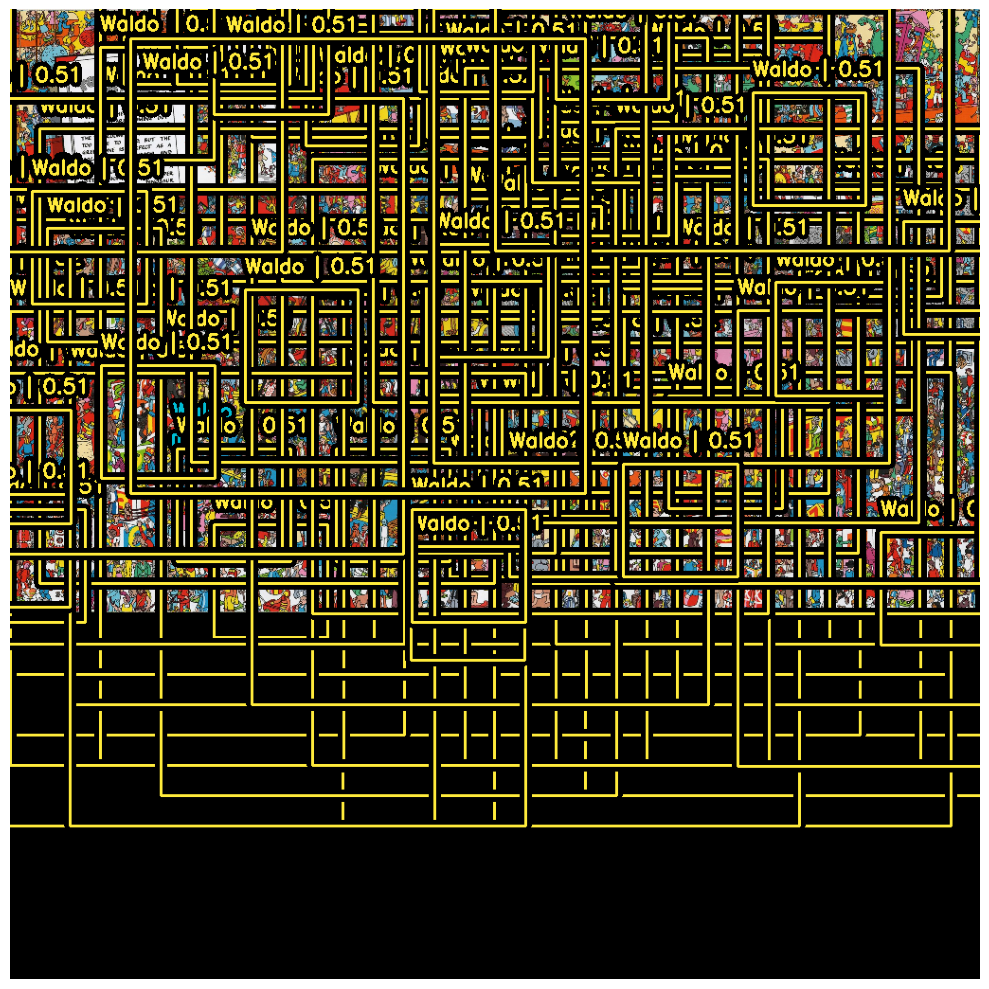

In [24]:
def visualize_detections(model, dataset, bounding_box_format):
    for i in range(8):
        images, y_true = next(iter(dataset.take(i+1)))
        y_pred = model.predict(images)
        # y_pred = bounding_box.to_ragged(y_pred) ### Doesn't work, seems important though
    visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            y_true=y_true,
            y_pred=y_pred,
            scale=10,
            rows=1,
            cols=1,
            show=True,
            font_scale=0.7,
            class_mapping=class_mapping,
        )
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

In [25]:
test, test_true = next(iter(val_ds.take(1)))
results = yolo.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step
